<h1 style="color: purple;">ANALISI DEI PICCHI DEL CAMPIONE CON QD: C240920</h1>

<hr style="border: 3px solid purple;">

## IMPORTAZIONI

---

In [1]:
from picchi_C240920 import raccoglitore_qd
from analisi_subroutines import *

<hr style="border: 3px solid purple;">

## ESTRAZIONE DEI PICCHI


---

Nella key Regione 1 (che è una list) è ci sono due quadruple (mu, 0, sigma, A) che corrispondono ai due picchi presenti: quello dell'AlGaAs e quello dei QD. Nella key Regione 2 sono presenti tre picchi oppure due, ma bisogna tenere a mente che uno è in più, usato unicamente per far funzionare meglio il fit. Il primo d'interesse è quello che dà la gaussiana più alta (GaAs): quello viene selezionato sempre. A 15K, quando sono presenti tre picchi, oltre al più alto si va a selezionare il picco di difetto, posizionato attorno ai 830nm, che è il secondo più alto.

Nel raccoglitore, i picchi sono già distribuiti con mu in ordine crescente, perciò:

REGIONE 1:
- quando ho 2 picchi (15K, 30K, 45K), il primo è dell'AlGaAs e il secondo del QD
- quando ho 1 solo picco (70K, 100K), è quello del QD

REGIONE 2:
- prendo sempre il picco che dà gaussiana più alta (GaAs)
- quando ho 2 picchi, prendo solo il GaAs
- quando ho 3 picchi, prendo il GaAs e il secondo più alto (difetto)

### Funzioni

In [2]:
def estrai_picchi_regione_1 (lista_picchi):
    
    ## REGIONE 1 ##
    if len(lista_picchi) == 2:
        A1, mu1, sigma1 = lista_picchi[0][3], lista_picchi[0][0], lista_picchi[0][2]
        AlGaAs = (A1, mu1, sigma1)
        A2, mu2, sigma2 = lista_picchi[1][3], lista_picchi[1][0], lista_picchi[1][2]
        QD = (A2, mu2, sigma2)
        
        return AlGaAs, QD
        
    elif len(lista_picchi) == 1:
        A2, mu2, sigma2 = lista_picchi[0][3], lista_picchi[0][0], lista_picchi[0][2]
        QD = (A2, mu2, sigma2)
        
        return QD
    
    else:
        raise ValueError("Numero di picchi inaspettato:", len(lista_picchi))

def estrai_picchi_regione_2 (lista_picchi):
    
    ## REGIONE 2 ##
    n_picchi2 = len(lista_picchi)
    massimi = []
    # cerco la gaussiana più alta
    for i in range(n_picchi2):
        A, mu, sigma = lista_picchi[i][3], lista_picchi[i][0], lista_picchi[i][2]
    
        x = np.linspace(800, 850, 50)
        # calcolo la gaussiana
        y = gaussiana(x, A, mu, sigma)
        # estraggo il massimo
        y_max = np.max(y)
        massimi.append(y_max)
    
    # prendo l'indice del massimo, quindi il picco del GaAs che gli corrisponde
    i_max = np.argmax(massimi)
    GaAs = (lista_picchi[i_max][3], lista_picchi[i_max][0], lista_picchi[i_max][2])
    
    # ora restano da vedere gli altri: se ce n'è soltanto due ho finito
    if n_picchi2 == 2:
        return GaAs
    # se invece ce ne sono tre, va preso il secondo più alto
    elif n_picchi2 == 3:
        indici_rimanenti = [i for i in range(3) if i != i_max]
        
        # Trova l'indice del secondo massimo tra quelli rimanenti
        i_secondo = max(indici_rimanenti, key=lambda i: massimi[i])
        difetto = (lista_picchi[i_secondo][3], lista_picchi[i_secondo][0], lista_picchi[i_secondo][2])
        
        return GaAs, difetto
    
    else: 
        raise ValueError("Numero di picchi inaspettato:", len(lista_picchi))

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### Contenitori per picchi

In [3]:
picchi_GaAs = {}
picchi_QD = {}
picchi_AlGaAs = {}
picchi_difetto = {}

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

#### Estrazione tramite funzioni

In [4]:

for ass in d_o_ass:
    ass = 'ass=' + ass 
    emi_list = d_o_emi[1:] if ass == 'ass=0' else ['0']  # Per ass=1 usa solo emi='0'
    
    # Per ciascuno degli emi > 0 se ass=0, solo emi=0 se ass=1
    for emi in emi_list:
        emi = 'emi=' + emi
        
        picchi_AlGaAs[ass+emi] = []
        picchi_QD[ass+emi]   = []
        picchi_GaAs[ass+emi]  = []
        picchi_difetto[ass+emi] = []
        
        for i, temp in enumerate(arr_temperatura):
            
            ## REGIONE 1 ##
            # a 15, 30, 45 ci sono entrambi
            if temp in (15, 30, 45):
                picco1, picco2 = estrai_picchi_regione_1(raccoglitore_qd[ass][emi][i]['Regione 1'])
                picchi_AlGaAs[ass+emi].append(picco1)
                picchi_QD[ass+emi].append(picco2)
            elif temp in (70, 100):
                picco1 = (np.nan, 0, np.nan, np.nan)
                picco2 = estrai_picchi_regione_1(raccoglitore_qd[ass][emi][i]['Regione 1'])
                picchi_AlGaAs[ass+emi].append(picco1)
                picchi_QD[ass+emi].append(picco2)
            else:
                picco1 = (np.nan, 0, np.nan, np.nan)
                picco2 = (np.nan, 0, np.nan, np.nan)
                picchi_AlGaAs[ass+emi].append(picco1)
                picchi_QD[ass+emi].append(picco2)
                
            ## REGIONE 2 ##
                
            # il difetto c'è solo a 15K
            if temp == 15:
                picco1, picco2 = estrai_picchi_regione_2(raccoglitore_qd[ass][emi][i]['Regione 2'])
                picchi_GaAs[ass+emi].append(picco1)
                picchi_difetto[ass+emi].append(picco2)
            else:
                picco1 = estrai_picchi_regione_2(raccoglitore_qd[ass][emi][i]['Regione 2'])
                picco2 = (np.nan, 0, np.nan, np.nan)
                picchi_GaAs[ass+emi].append(picco1)
                picchi_difetto[ass+emi].append(picco2)

Ora i picchi sono contenuti nei loro rispettivi contenitori. Questi hanno key [ass+emi], al cui interno si trovano liste di triple (A, mu, sigma). Chiaramente, in funzione delle temperature a cui si osserva un determinato picco, ci saranno più o meno triple: ad esempio il difetto, osservato solo a 15K, ha una sola tripla, gli altri oggetti sono np.nan.

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### Conversione in eV

È un'iterazione in più inutile, ma almeno rende il codice più leggibile. Stavolta nelle list ci sono delle quadruple (A, mu, sigma, err_mu); l'errore su mu è calcolato a partire dalla risoluzione dell'apparato.

In [5]:
AlGaAs_ev  = {}
QD_ev   = {}
GaAs_ev = {}
difetto_ev = {}

In [6]:
for ass in d_o_ass:
    ass = 'ass=' + ass 
    emi_list = d_o_emi[1:] if ass == 'ass=0' else ['0']  # Per ass=1 usa solo emi='0'
    
    # Per ciascuno degli emi > 0 se ass=0, solo emi=0 se ass=1
    for emi in emi_list:
        emi = 'emi=' + emi
        
        AlGaAs_ev[ass+emi] = []
        QD_ev[ass+emi] = []
        GaAs_ev[ass+emi] = []
        difetto_ev[ass+emi] = []

        for i, temp in enumerate(arr_temperatura):
            
            ## AlGaAs ##
            A1 = picchi_AlGaAs[ass+emi][i][0]
            
            if np.isnan(A1):
                AlGaAs_ev[ass+emi].append((np.nan, np.nan, np.nan, np.nan))
            else:
                mu1 = picchi_AlGaAs[ass+emi][i][1]
                sigma1 = picchi_AlGaAs[ass+emi][i][2]
                err_mu1 = err_lambda_to_E(mu1, 0.7508320802)
                
                AlGaAs_ev[ass+emi].append((A1, lambda_to_E(mu1), err_lambda_to_E(mu1, sigma1), err_mu1))
                
            ## QD ##
            A2 = picchi_QD[ass+emi][i][0]
            
            if np.isnan(A2):
                QD_ev[ass+emi].append((np.nan, np.nan, np.nan, np.nan))
            else:
                mu2 = picchi_QD[ass+emi][i][1]
                sigma2 = picchi_QD[ass+emi][i][2]
                err_mu2 = err_lambda_to_E(mu2, 0.7508320802)
                
                QD_ev[ass+emi].append((A2, lambda_to_E(mu2), err_lambda_to_E(mu2, sigma2), err_mu2))
            
            ## GaAs ##
            A3 = picchi_GaAs[ass+emi][i][0]
            
            if np.isnan(A3):
                GaAs_ev[ass+emi].append((np.nan, np.nan, np.nan, np.nan))
            else:
                mu3 = picchi_GaAs[ass+emi][i][1]
                sigma3 = picchi_GaAs[ass+emi][i][2]
                err_mu3 = err_lambda_to_E(mu3, 0.7508320802)
                
                GaAs_ev[ass+emi].append((A3, lambda_to_E(mu3), err_lambda_to_E(mu3, sigma3), err_mu3))
            
            ## DIFETTO ##
                
            A4 = picchi_difetto[ass+emi][i][0]
            
            if np.isnan(A4):
                difetto_ev[ass+emi].append((np.nan, np.nan, np.nan, np.nan))
            else:
                mu4 = picchi_difetto[ass+emi][i][1]
                sigma4 = picchi_difetto[ass+emi][i][2]
                err_mu4 = err_lambda_to_E(mu4, 0.7508320802)
                
                difetto_ev[ass+emi].append((A4, lambda_to_E(mu4), err_lambda_to_E(mu4, sigma4), err_mu4))

<hr style="border: 3px solid purple;">

## FUNZIONI PER PLOT

---

### PER PLOT SU T

Usare: plot_su_T (picchi, option, x=None, d_o_ass=None, d_o_emi=None, arr_temperatura=None, col=None, materiale=None)

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### PER PLOT SU INT

Usare: plot_su_int (picchi, option, x=None, d_o_ass=None, d_o_emi=None, arr_temperatura=None, col=None, materiale=None)

<hr style="border: 3px solid purple;"> 

<hr style="border: 3px solid purple;"> 

# AlGaAs

---

## ENERGIA AlGaAs

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### ENERGIA SU TEMPERATURA AlGaAs

Con fit Varshni.

RISULTATI FIT VARSHNI
- - - - - - - - - - - - - - - - < emi=0 & ass=1 > - - - - - - - - - - - - - - - -
E_0 = 1.7088 ± 0.0018 | alpha = 10.2850 ± 5.3532 | beta = 3908861.2860 ± 0.0000
• Chi quadro ridotto: 0.067/0=inf
- - - - - - - - - - - - - - - - < emi=0o5 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.7066 ± 0.0018 | alpha = 29.3160 ± 9.8677 | beta = 7239519.7879 ± 0.0000
• Chi quadro ridotto: 0.031/0=inf
- - - - - - - - - - - - - - - - < emi=1 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.7066 ± 0.0037 | alpha = 0.0008 ± 0.0073 | beta = 144.5014 ± 1749.1106
• Chi quadro ridotto: 0.000/0=inf
- - - - - - - - - - - - - - - - < emi=1o5 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.7055 ± 0.0034 | alpha = 0.0028 ± 0.0409 | beta = 386.4236 ± 6316.9239
• Chi quadro ridotto: 0.000/0=inf
- - - - - - - - - - - - - - - - < emi=2 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.7074 ± 0.0041 | alpha = 0.0013 ± 0.0031 | beta = 82.5342 ± 334.1209
• Chi quadro ridotto: 0.000/0=inf
- 

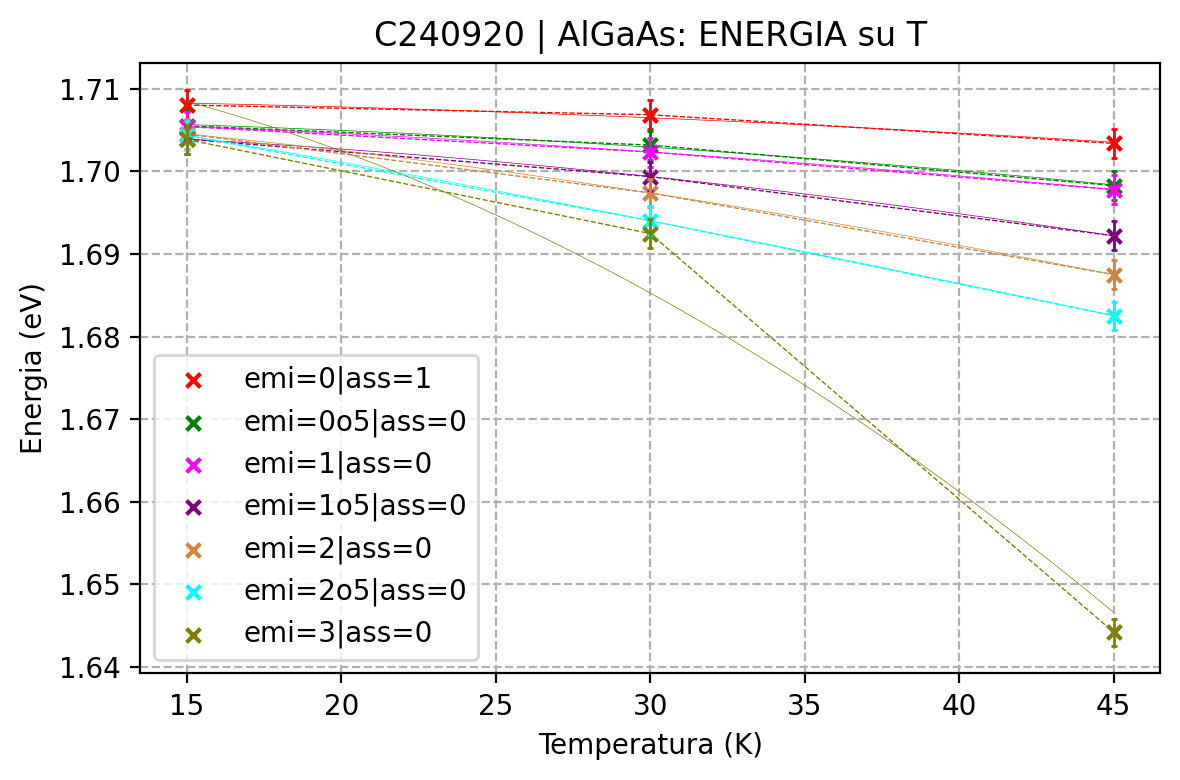

In [7]:
plot_su_T(AlGaAs_ev, 'mu', col=col, materiale='AlGaAs', campione='C240920', VARSHNI=True)

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### ENERGIA SU INTENSITÀ AlGaAs

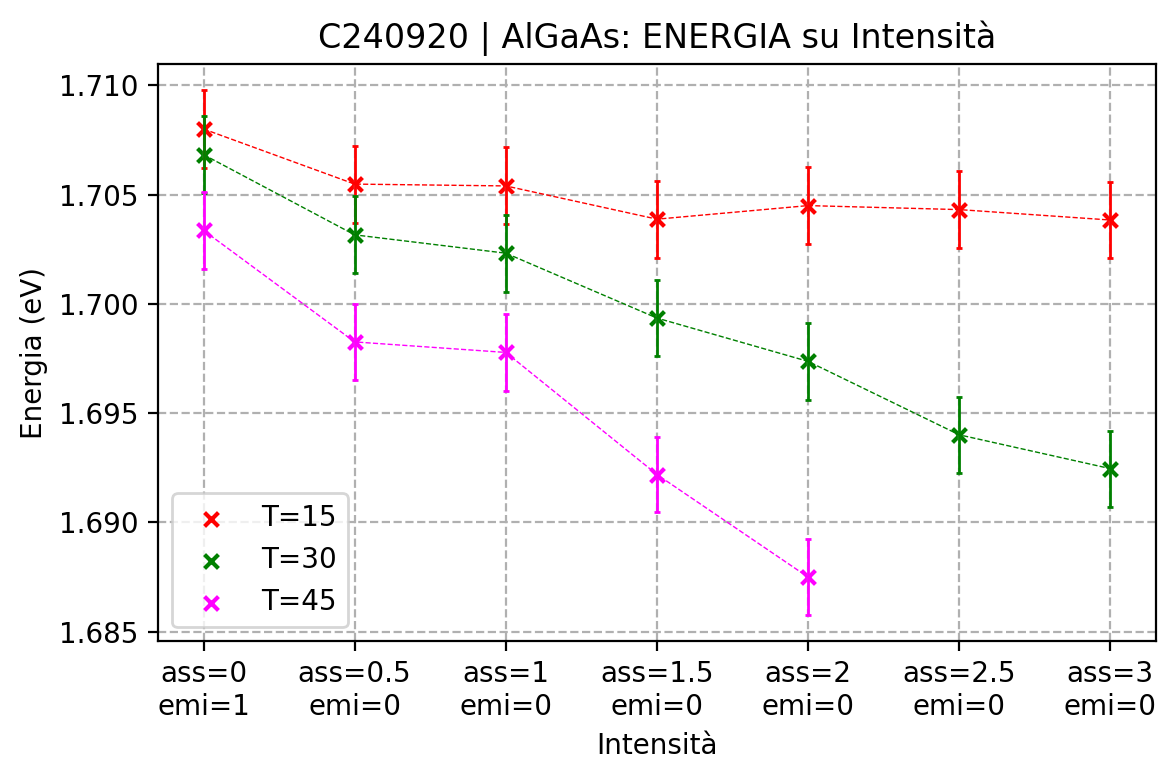

In [8]:
plot_su_int(AlGaAs_ev, 'mu', col=col, materiale='AlGaAs', campione='C240920')

---

## FWHM AlGaAs

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### FWHM SU TEMPERATURA AlGaAs

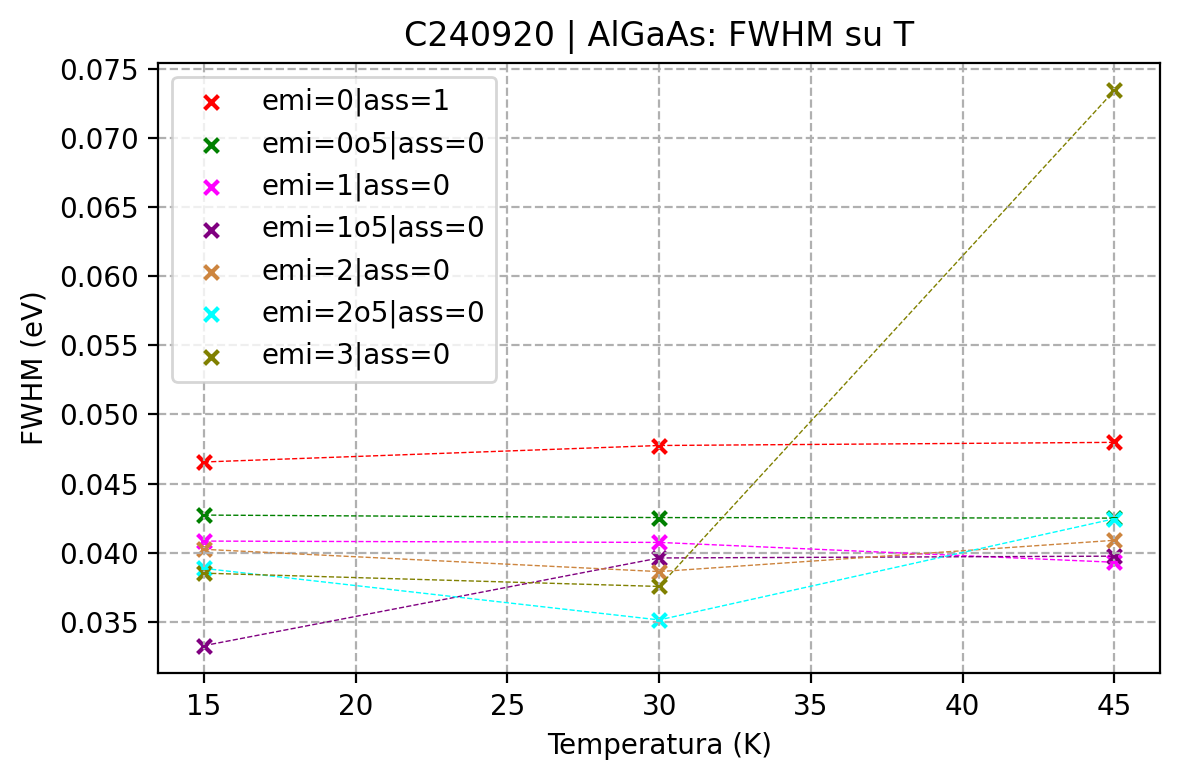

In [9]:
plot_su_T(AlGaAs_ev, 'fwhm', col=col, materiale='AlGaAs', campione='C240920')

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### FWHM SU INTENSITÀ AlGaAs

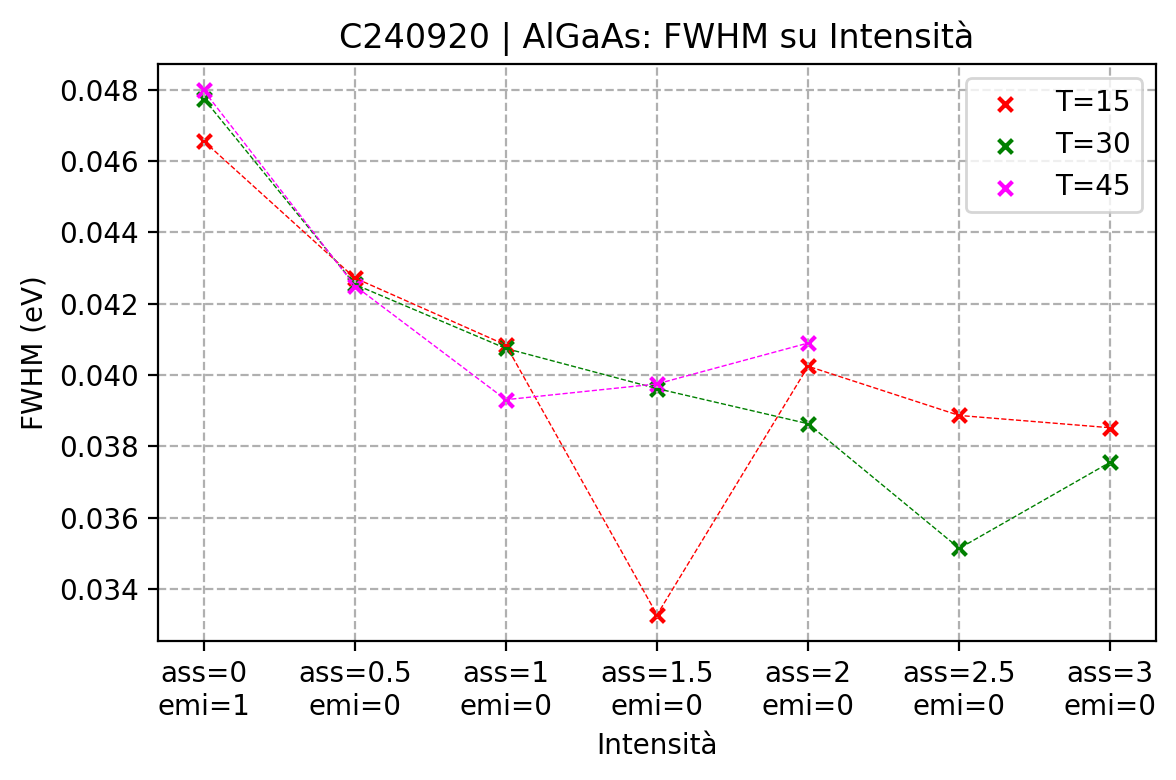

In [10]:
plot_su_int(AlGaAs_ev, 'fwhm', col=col, materiale='AlGaAs', campione='C240920')

---

## AREA AlGaAs

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### AREA SU TEMPERATURA AlGaAs

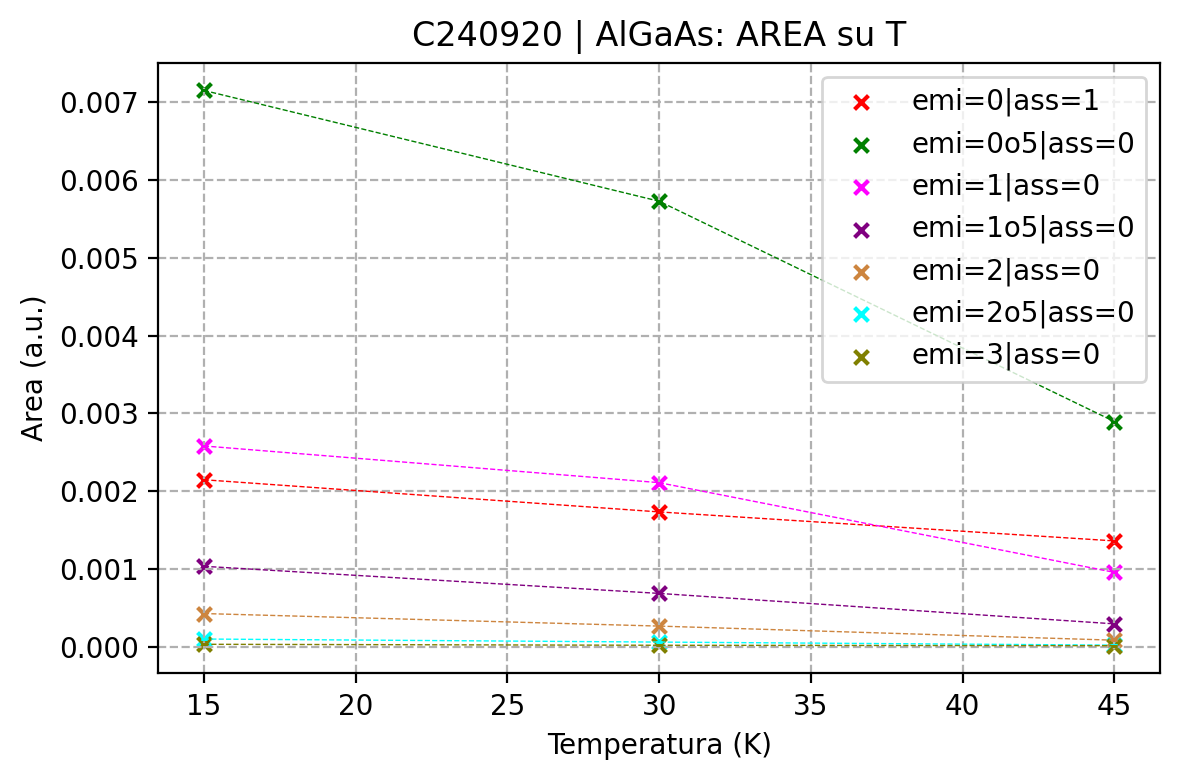

In [11]:
plot_su_T(AlGaAs_ev, 'area', col=col, materiale='AlGaAs', campione='C240920')

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### AREA SU INTENSITÀ AlGaAs

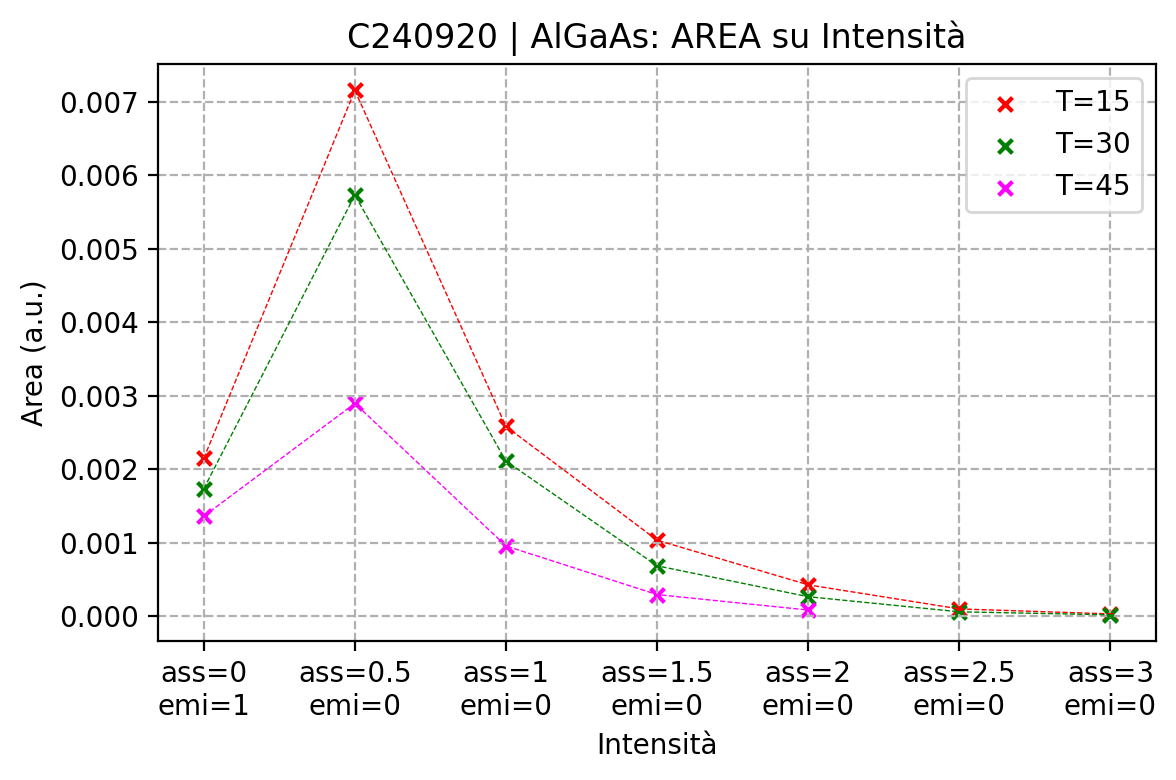

In [12]:
plot_su_int(AlGaAs_ev, 'area', col=col, materiale='AlGaAs', campione='C240920')

<hr style="border: 3px solid purple;"> 

<hr style="border: 3px solid purple;"> 

# QD

---

## ENERGIA QD

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### ENERGIA SU TEMPERATURA QD

Con dimostrazione che Varshni non fitta bene.

Notare che, al variare dell'intensità, le curve traslano notevolmente sull'asse y, cosa che non avviene (almeno in maniera così evidente) in GaAs e AlGaAs bulk.

RISULTATI FIT VARSHNI
- - - - - - - - - - - - - - - - < emi=0 & ass=1 > - - - - - - - - - - - - - - - -
E_0 = 1.6506 ± 0.0010 | alpha = 272.3852 ± 14.8591 | beta = 74406656.2569 ± 0.0001
• Chi quadro ridotto: 42.162/2=21.081
- - - - - - - - - - - - - - - - < emi=0o5 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.6444 ± 0.0010 | alpha = 275.7972 ± 10.9398 | beta = 55773578.0783 ± 0.0001
• Chi quadro ridotto: 30.935/2=15.468
- - - - - - - - - - - - - - - - < emi=1 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.6281 ± 0.0010 | alpha = 224.3346 ± 11.0436 | beta = 56919737.9306 ± 0.0000
• Chi quadro ridotto: 15.339/2=7.669
- - - - - - - - - - - - - - - - < emi=1o5 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.6158 ± 0.0010 | alpha = 237.9413 ± 13.5633 | beta = 70616467.5528 ± 0.0000
• Chi quadro ridotto: 8.314/2=4.157
- - - - - - - - - - - - - - - - < emi=2 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.6101 ± 0.0010 | alpha = 228.8622 ± 13.6498 | beta = 71471183.7540 ± 0.0000


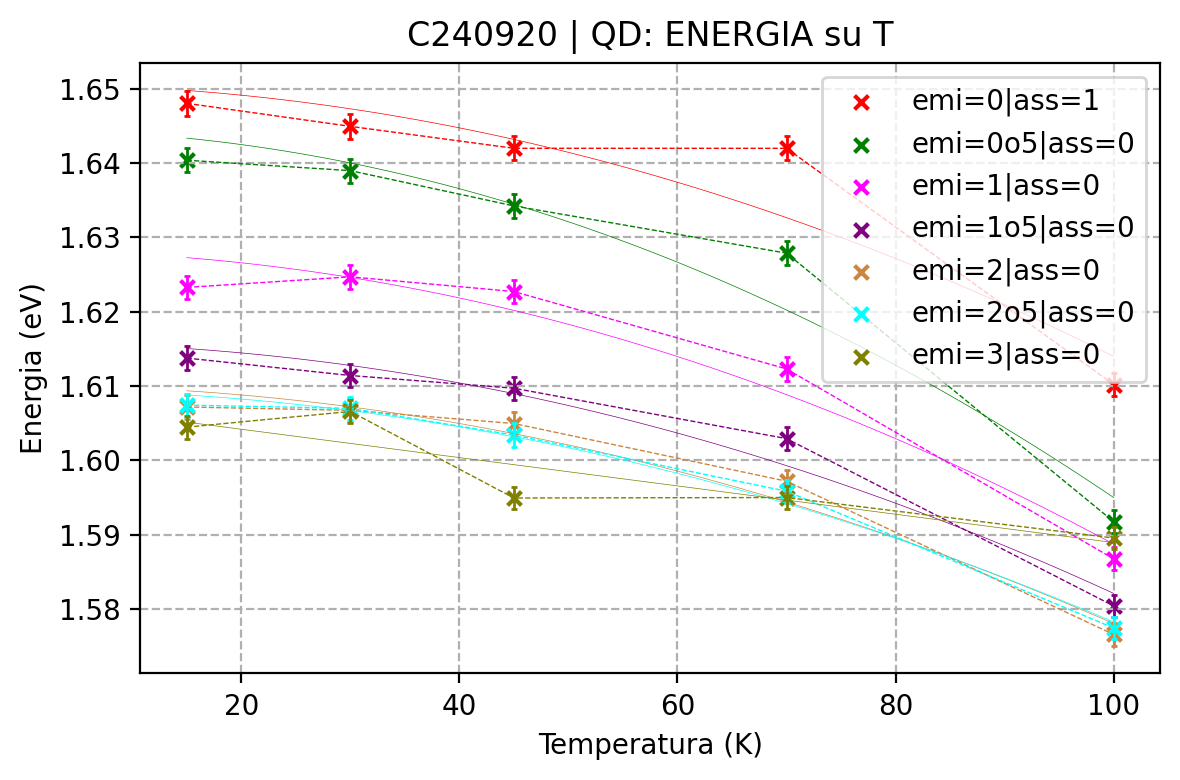

In [13]:
plot_su_T(QD_ev, 'mu', col=col, materiale='QD', campione='C240920', VARSHNI=True)

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### ENERGIA SU INTENSITÀ QD

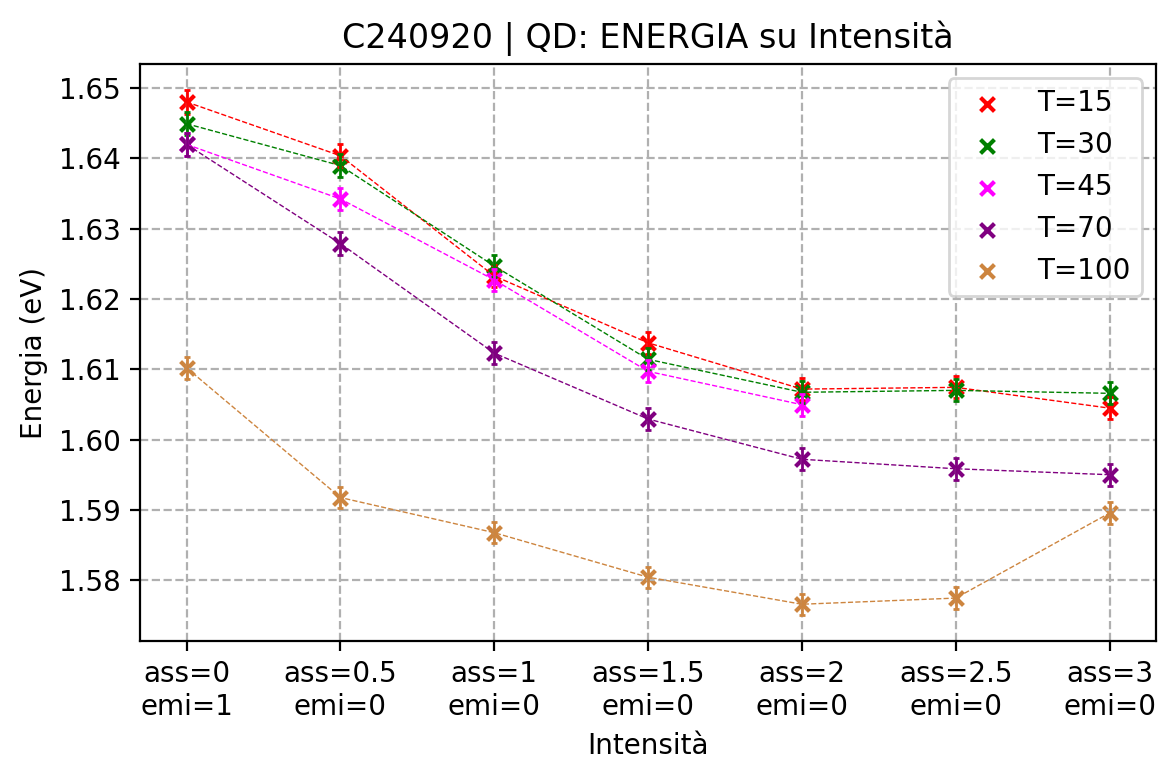

In [14]:
plot_su_int(QD_ev, 'mu', col=col, materiale='QD', campione='C240920')

---

## FWHM QD

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### FWHM SU TEMPERATURA QD

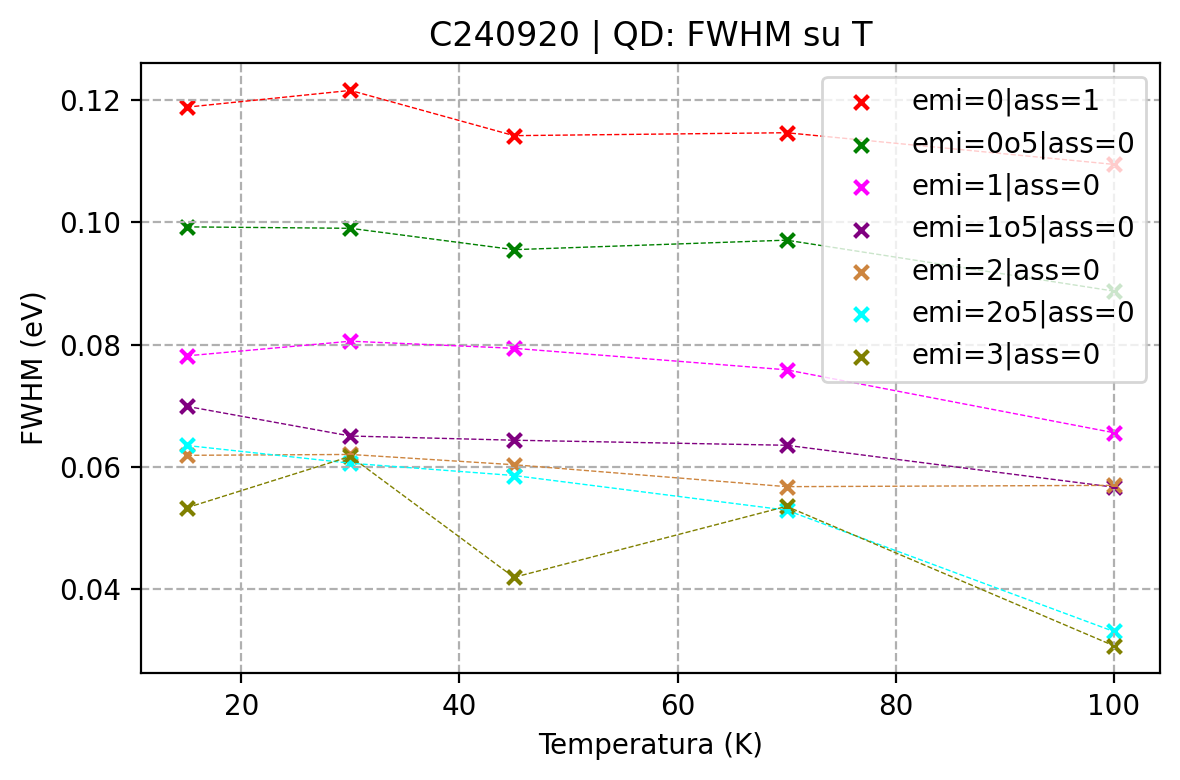

In [15]:
plot_su_T(QD_ev, 'fwhm', col=col, materiale='QD', campione='C240920')

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### FWHM SU INTENSITÀ QD

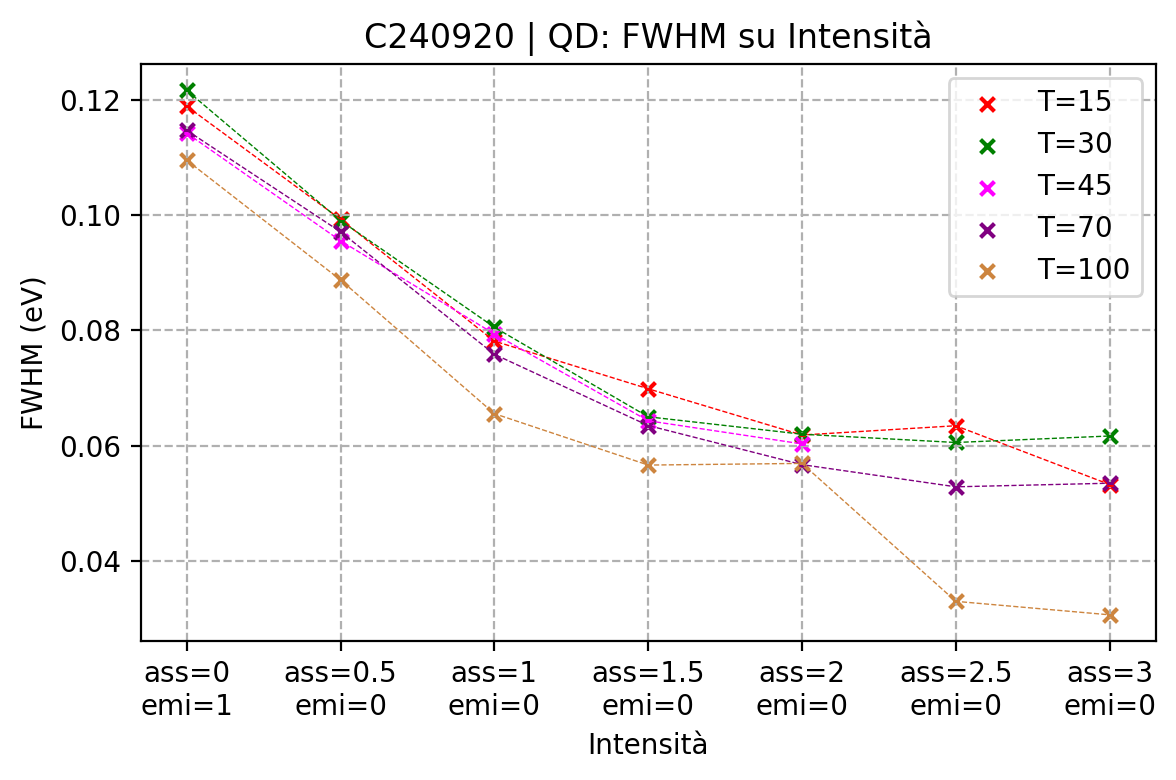

In [16]:
plot_su_int(QD_ev, 'fwhm', col=col, materiale='QD', campione='C240920')

---

## AREA QD

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### AREA SU TEMPERATURA QD

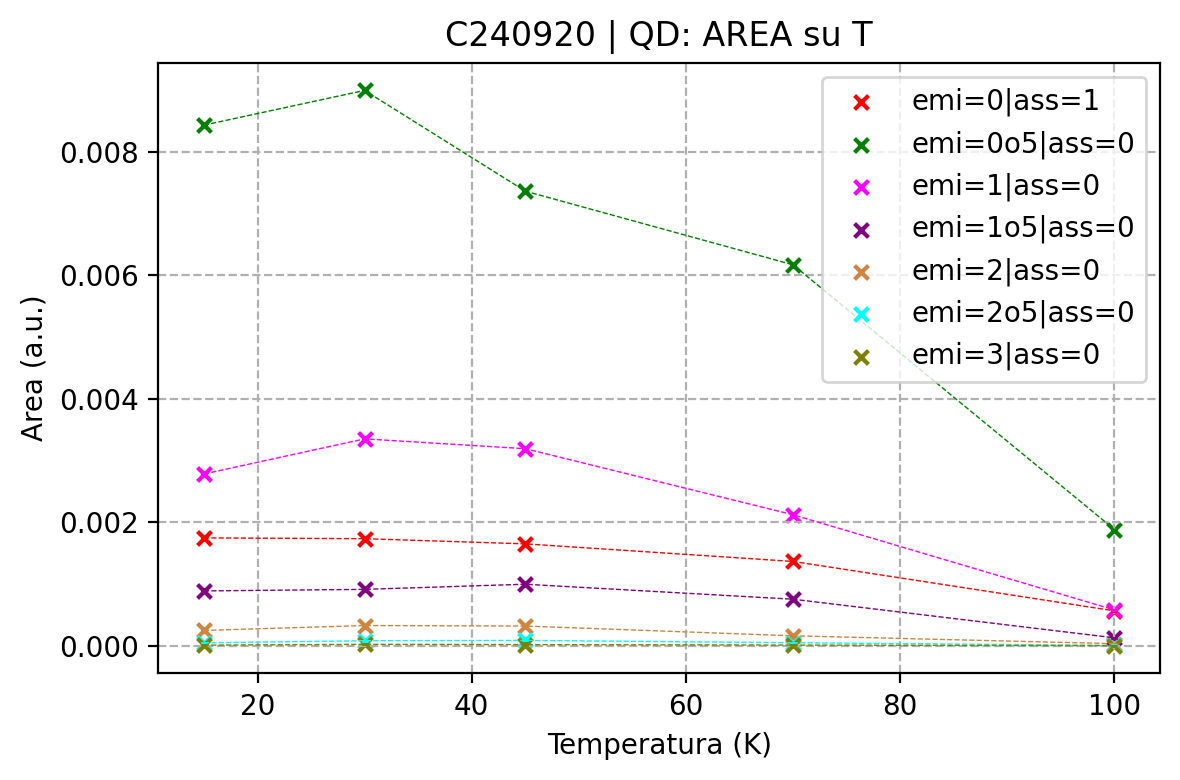

In [17]:
plot_su_T(QD_ev, 'area', col=col, materiale='QD', campione='C240920')

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### AREA SU INTENSITÀ QD

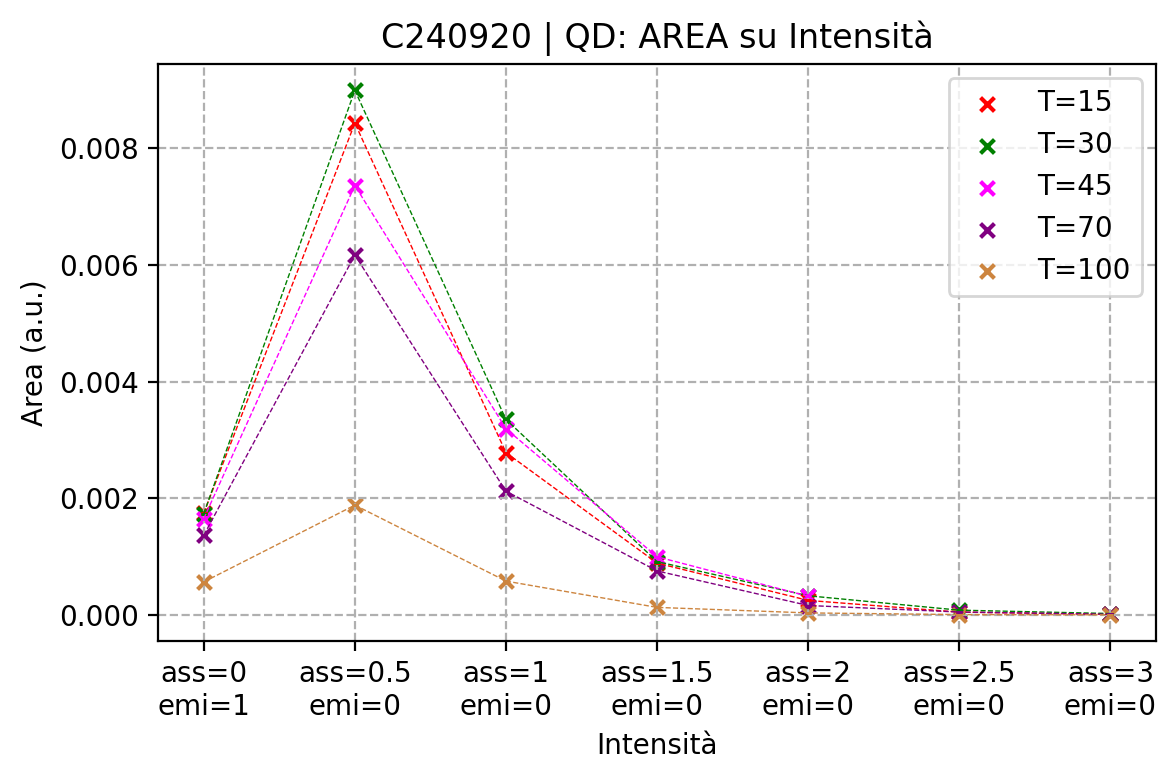

In [18]:
plot_su_int(QD_ev, 'area', col=col, materiale='QD', campione='C240920')

<hr style="border: 3px solid purple;"> 

<hr style="border: 3px solid purple;"> 

# GaAs

---

## ENERGIA GaAs

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### ENERGIA SU TEMPERATURA GaAs

Con fit Varshni.

RISULTATI FIT VARSHNI
- - - - - - - - - - - - - - - - < emi=0 & ass=1 > - - - - - - - - - - - - - - - -
E_0 = 1.5173 ± 0.0008 | alpha = 82.9561 ± 4.6199 | beta = 64769548.8917 ± 0.0000
• Chi quadro ridotto: 2.470/3=0.823
- - - - - - - - - - - - - - - - < emi=0o5 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.5160 ± 0.0007 | alpha = 145.8643 ± 8.3714 | beta = 117409564.2574 ± 0.0000
• Chi quadro ridotto: 0.757/3=0.252
- - - - - - - - - - - - - - - - < emi=1 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.5156 ± 0.0007 | alpha = 33.2897 ± 1.9360 | beta = 27156809.8282 ± 0.0000
• Chi quadro ridotto: 0.607/3=0.202
- - - - - - - - - - - - - - - - < emi=1o5 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.5154 ± 0.0007 | alpha = 408.1274 ± 23.9601 | beta = 336110339.0643 ± 0.0000
• Chi quadro ridotto: 0.871/3=0.290
- - - - - - - - - - - - - - - - < emi=2 & ass=0 > - - - - - - - - - - - - - - - -
E_0 = 1.5153 ± 0.0007 | alpha = 140.9688 ± 8.3355 | beta = 116932782.9122 ± 0.0000
• Chi qu

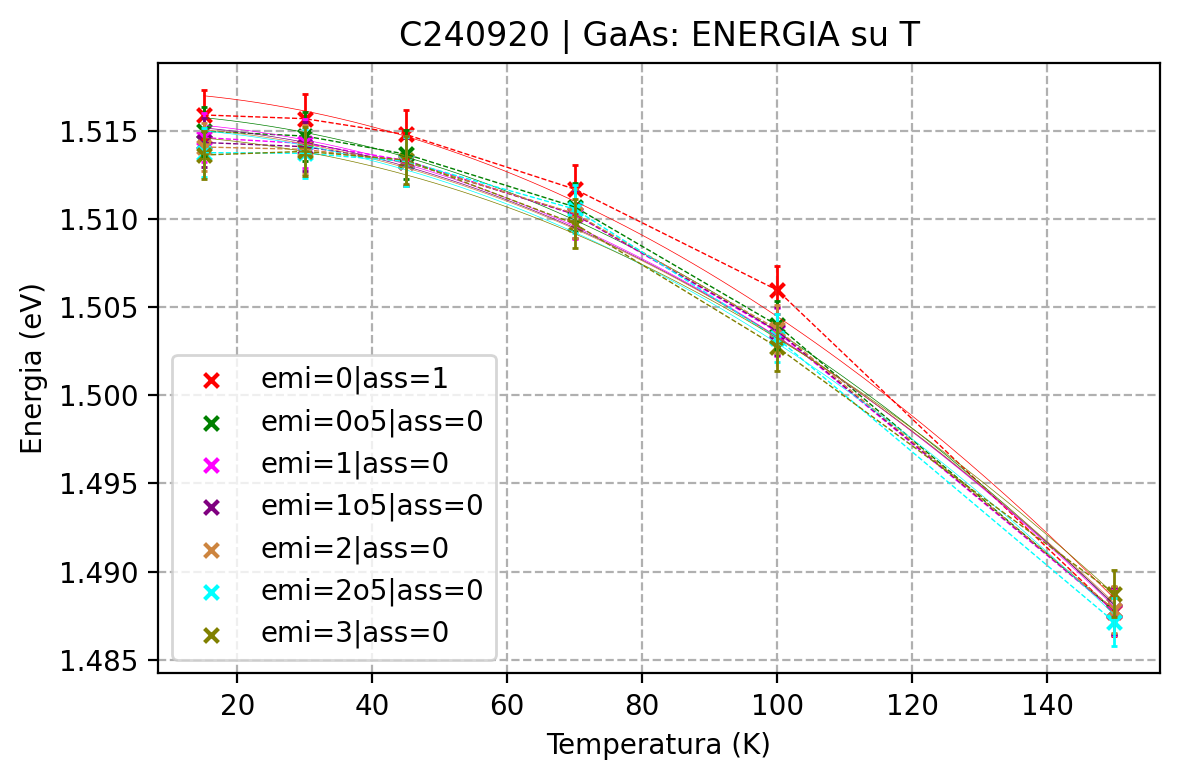

In [19]:
plot_su_T(GaAs_ev, 'mu', col=col, materiale='GaAs', campione='C240920', VARSHNI=True)

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### ENERGIA SU INTENSITÀ GaAs

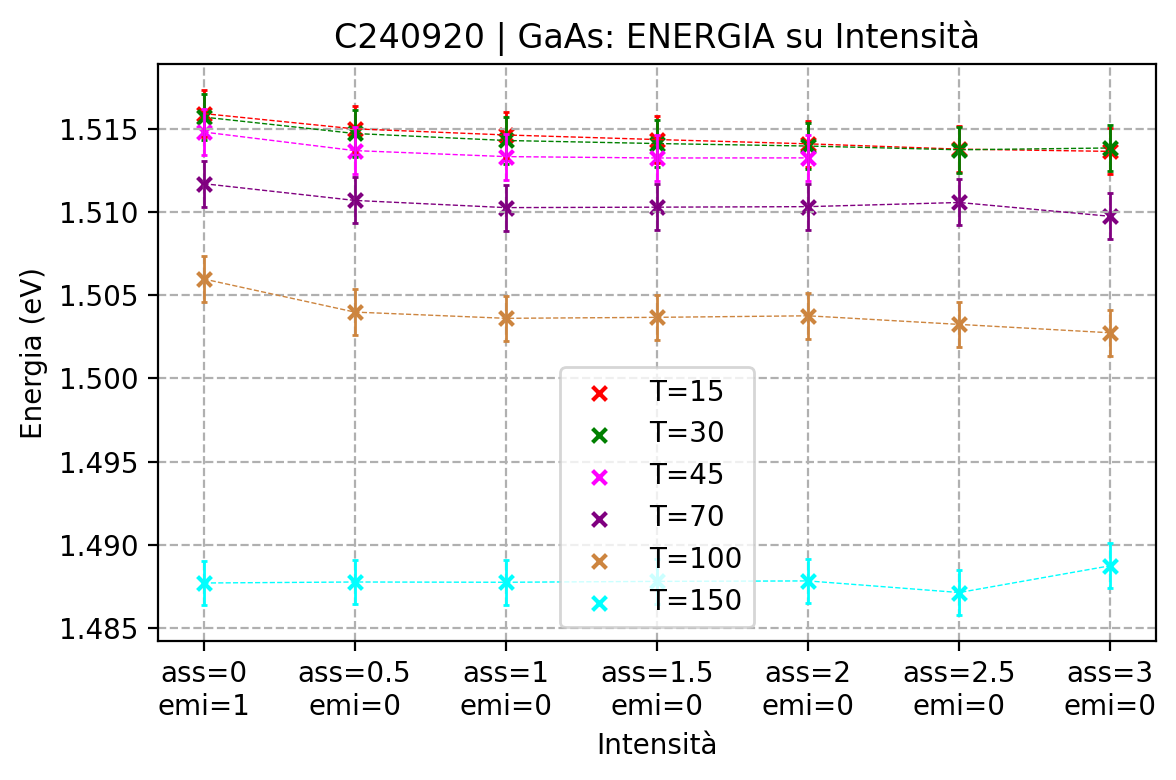

In [20]:
plot_su_int(GaAs_ev, 'mu', col=col, materiale='GaAs', campione='C240920')

---

## FWHM GaAs

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### FWHM SU TEMPERATURA GaAs

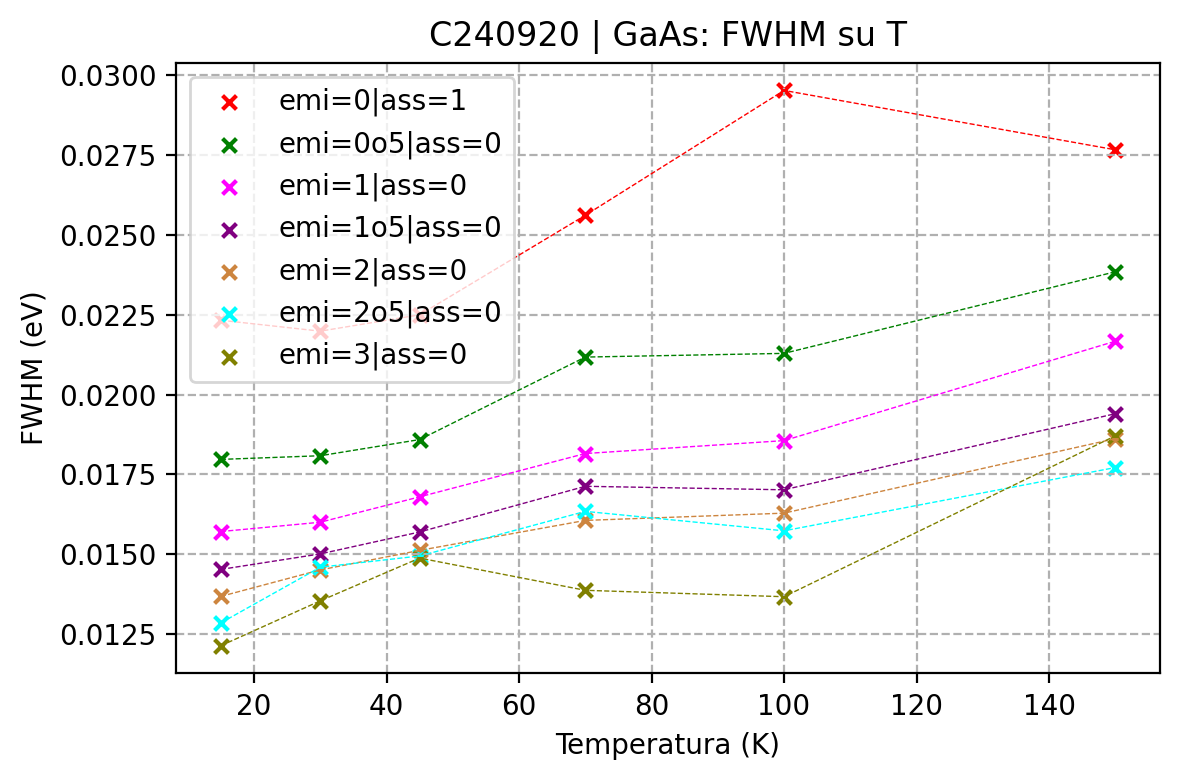

In [21]:
plot_su_T(GaAs_ev, 'fwhm', col=col, materiale='GaAs', campione='C240920')

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### FWHM SU INTENSITÀ GaAs

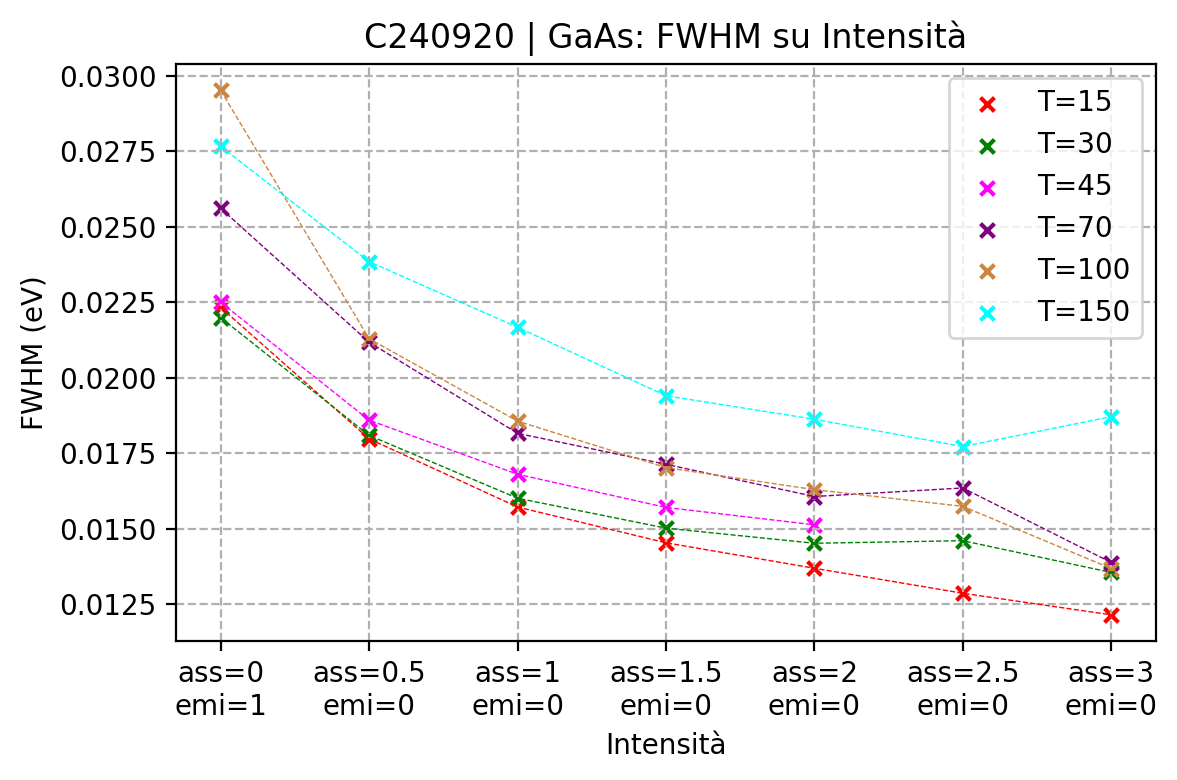

In [22]:
plot_su_int(GaAs_ev, 'fwhm', col=col, materiale='GaAs', campione='C240920')

---

## AREA GaAs

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### AREA SU TEMPERATURA GaAs

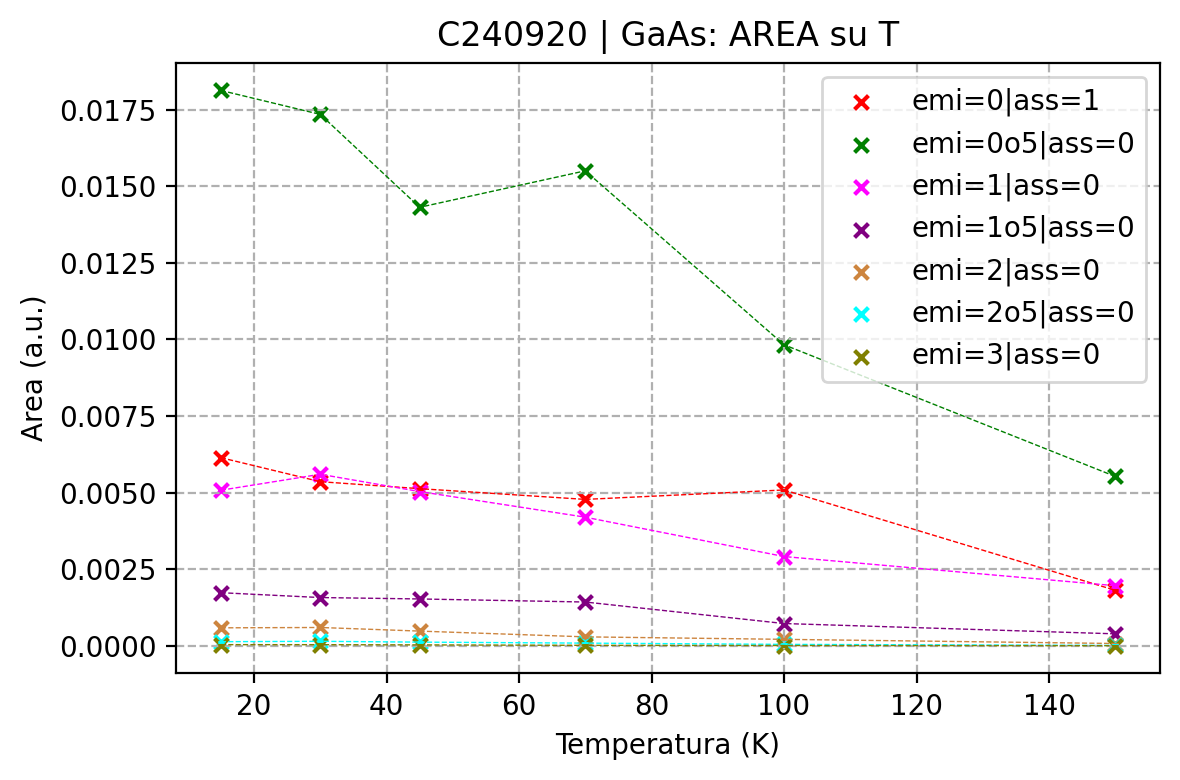

In [23]:
plot_su_T(GaAs_ev, 'area', col=col, materiale='GaAs', campione='C240920')

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### AREA SU INTENSITÀ GaAs

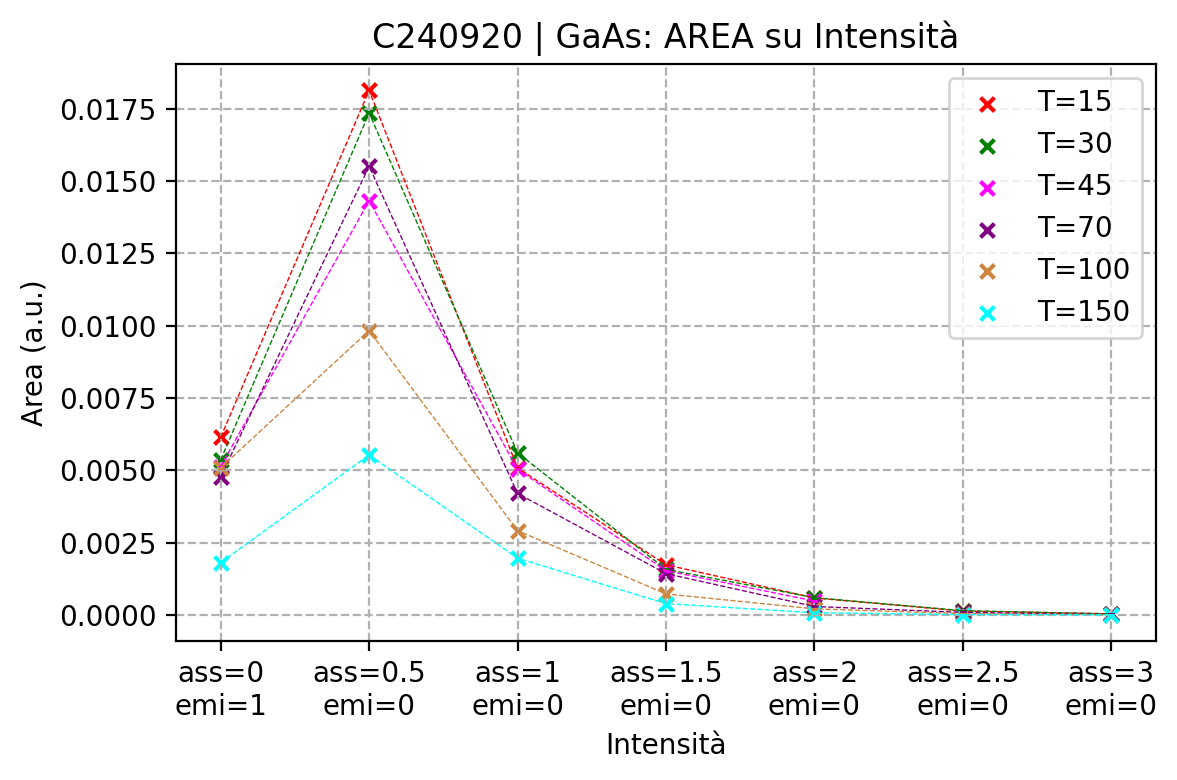

In [24]:
plot_su_int(GaAs_ev, 'area', col=col, materiale='GaAs', campione='C240920')

<hr style="border: 3px solid purple;"> 

<hr style="border: 3px solid purple;"> 

# DIFETTO

---

Il difetto c'è ad una sola temperatura, quindi plotto solo in funzione dell'intensità.

## ENERGIA Difetto

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### ENERGIA SU INTENSITÀ Difetto

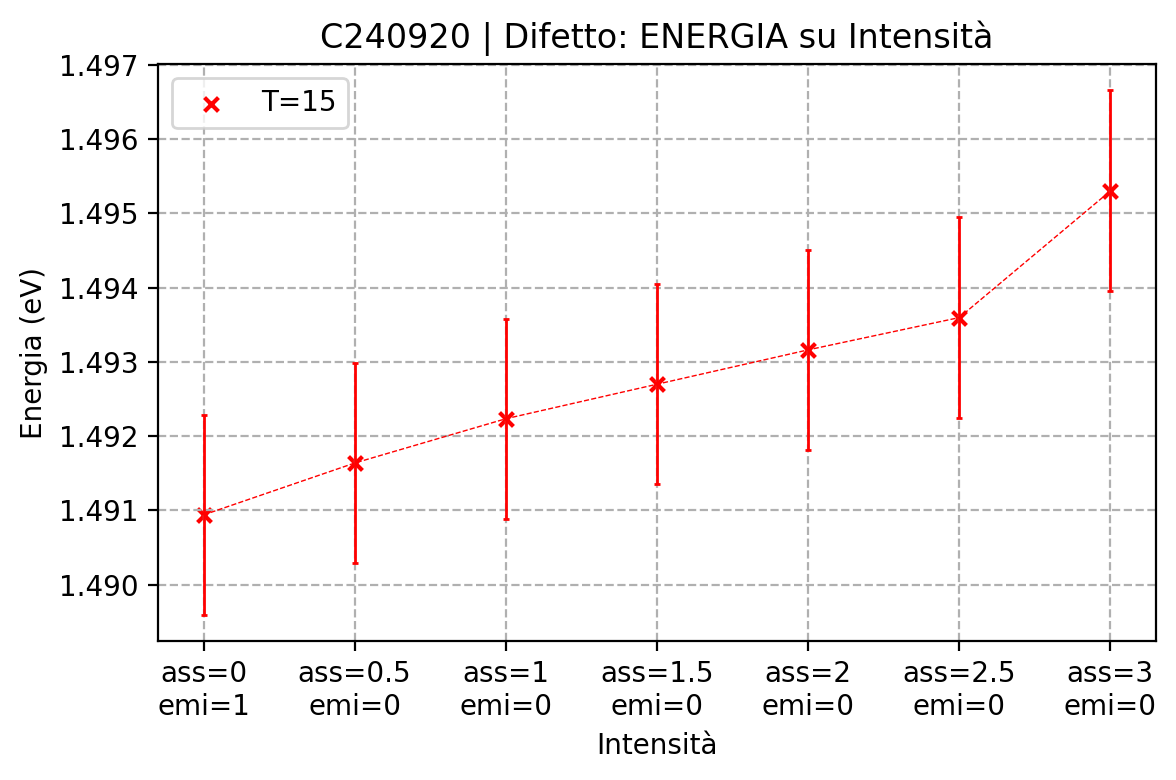

In [25]:
plot_su_int(difetto_ev, 'mu', col=col, materiale='Difetto', campione='C240920')

---

## FWHM Difetto

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### FWHM SU INTENSITÀ Difetto

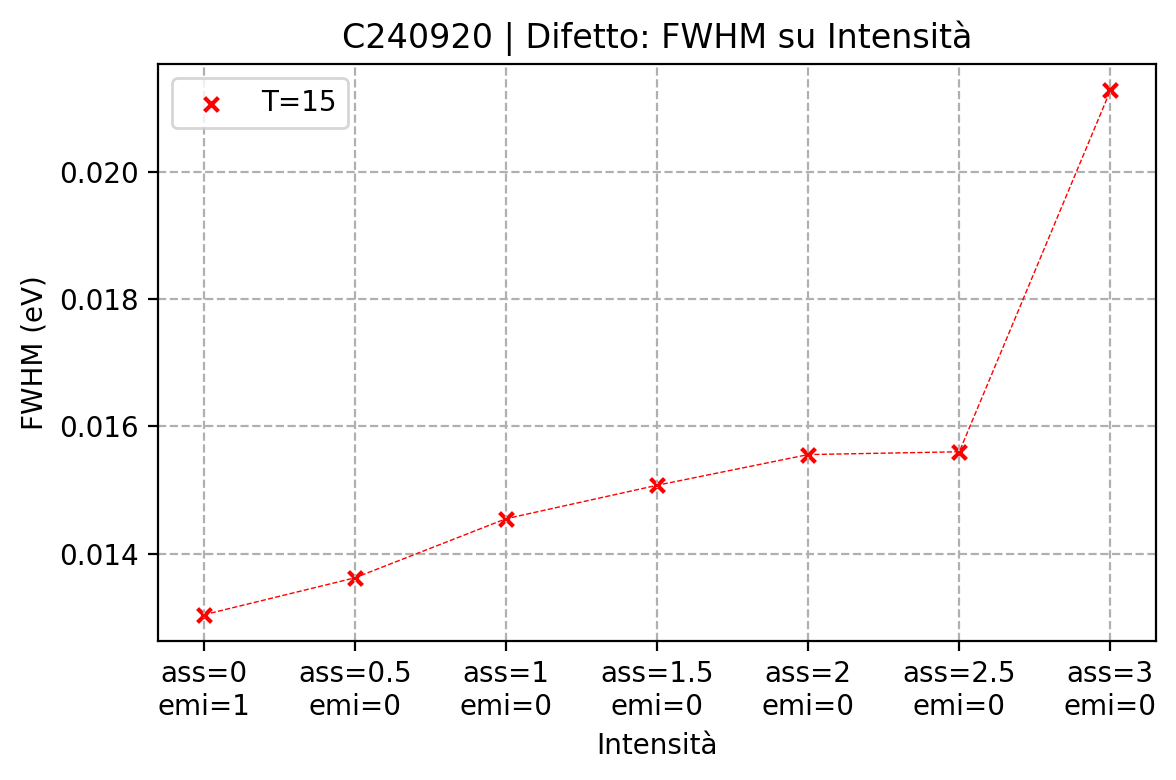

In [26]:
plot_su_int(difetto_ev, 'fwhm', col=col, materiale='Difetto', campione='C240920')

---

## AREA Difetto

<hr style="height: 2px; background: repeating-linear-gradient(to right, black, black 5px, transparent 5px, transparent 10px); border: none;">

### AREA SU INTENSITÀ Difetto

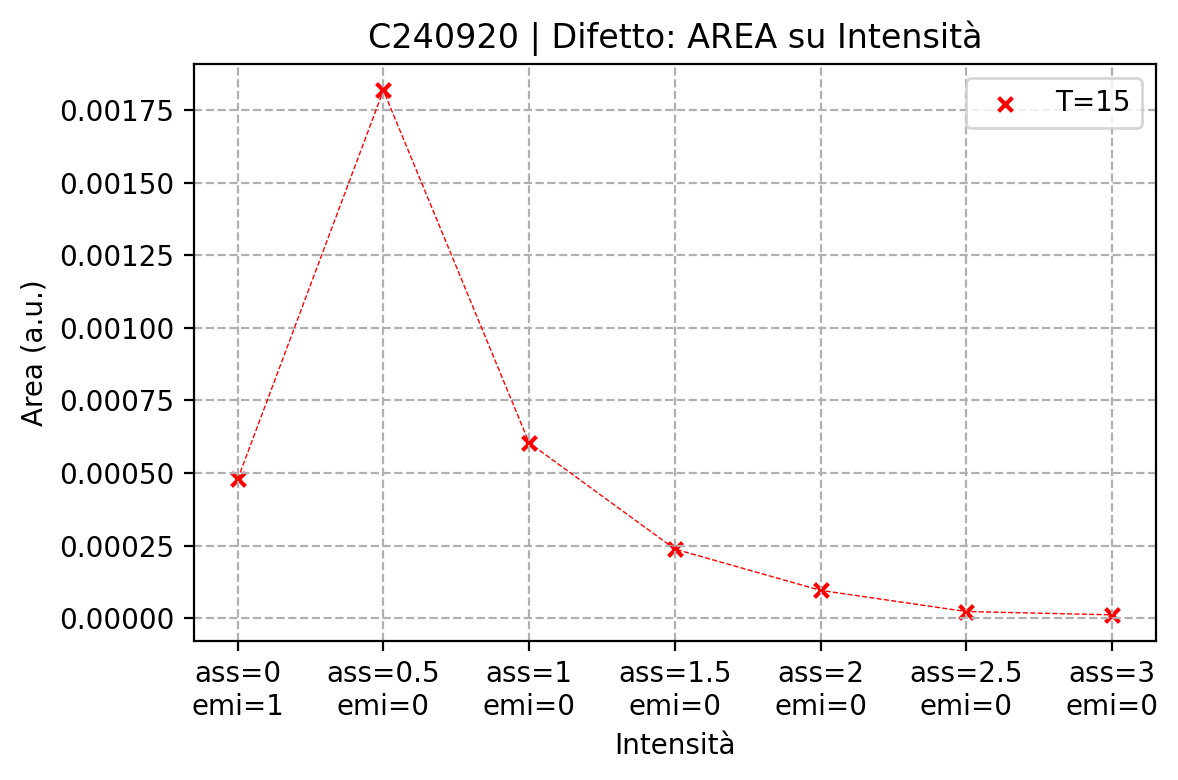

In [27]:
plot_su_int(difetto_ev, 'area', col=col, materiale='Difetto', campione='C240920')

<hr style="border: 3px solid purple;"> 

<hr style="border: 3px solid purple;"> 